# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
---

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


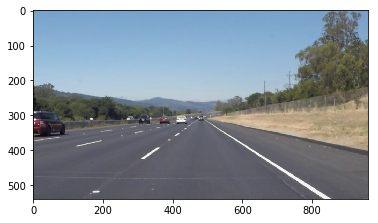

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def draw_onelines(img, lines, color = [255,0,0], thickness = 10):
    left_slope = 0
    N_L = 0
    right_slope = 0
    N_R = 0
    x1_left = 0
    x1_right = 0
    y1_left = 540
    y1_right = 540
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (x2 - x1) / (y2 - y1)        
            line_length = math.sqrt((x2 - x1) **2 + (y2 - y1) **2)
            if abs(slope) <= 0.3:
                continue
            if abs(slope) >=100.0:
                continue
            
            if line_length <= 15:
                continue
            
            # calc averagee of slope on both side
            if slope > 0: #it means line is on left
                left_slope = left_slope + slope
                N_L = N_L + 1
                if y1 < y1_left:
                    x1_left = x1 
                    y1_left = y1
            else: # it means line is on right
                right_slope = right_slope + slope
                N_R = N_R + 1
                if y1 < y1_right:
                    x1_right = x1
                    y1_right = y1
        
    left_slope_ave = left_slope/N_L
    right_slope_ave = right_slope/N_R
    y2_left = 540
    y2_right = 540
    x2_left = int(x1_left + (y2_left-y1_left) * left_slope_ave)
    x2_right = int(x1_right + (y2_right-y1_right) * right_slope_ave)
    
    cv2.line(img, (x1_left, y1_left), (x2_left, y2_left ), color, thickness)        
    cv2.line(img, (x1_right, y1_right), (x2_right, y2_right), color, thickness)
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_onelines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



In [27]:
#To show inside of pipeline, below pictures are outcome of each steps.
list_of_images = mpimg.imread("test_images/" + os.listdir("test_images/")[0])
grayed_images = grayscale(list_of_images)
grayed_images_filt = gaussian_blur(grayed_images, 5)
canny_images = canny(grayed_images_filt, 50, 150)
poly = np.array([[500,300],[100,500],[900,500]])
regione_images = region_of_interest(canny_images, [poly])
lines_images = hough_lines(regione_images, 1, np.pi/180, 20, 10, 5)
weighted_images = weighted_img(lines_images, list_of_images, α=0.8, β=1., γ=0.)

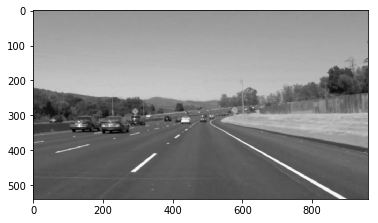

In [14]:
plt.imshow(grayed_images_filt, cmap="gray")

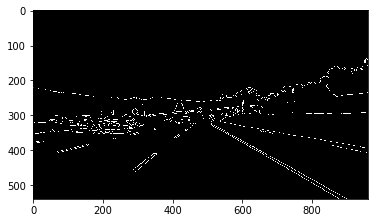

In [15]:
plt.imshow(canny_images, cmap="gray")

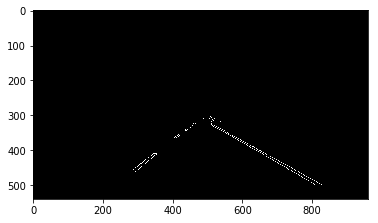

In [16]:
plt.imshow(regione_images, cmap="gray")

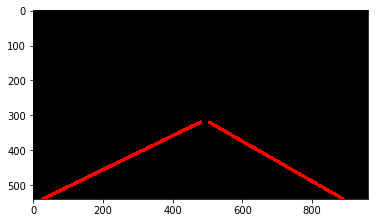

In [28]:
plt.imshow(lines_images, cmap="gray")

In [29]:
def extract_line (image_file):
    original_images = mpimg.imread(image_file)
    grayed_images = grayscale(original_images)
    grayed_images_filt = gaussian_blur(grayed_images, 5)
    canny_images = canny(grayed_images_filt, 50, 150)
    poly = np.array([[500,300],[100,500],[900,500]])
    regione_images = region_of_interest(canny_images, [poly])
    lines_images = hough_lines(regione_images, 1, np.pi/180, 20, 20, 5)
    weighted_images = weighted_img(lines_images, original_images, α=0.8, β=1., γ=0.)
    return weighted_images

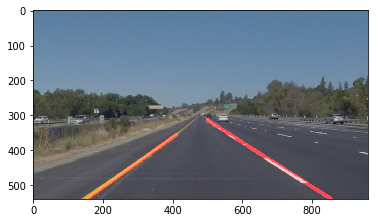

In [35]:
file = "test_images/" + os.listdir("test_images/")[4]
result = extract_line(file)
plt.imshow(result)

In [36]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [37]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # result = extract_line(image)
    # by some reason code above did not work....I just copied code from "pipeline" and pasted below then worked. Couldn't figure out reason...
    grayed_images = grayscale(image)
    grayed_images_filt = gaussian_blur(grayed_images, 5)
    canny_images = canny(grayed_images_filt, 50, 150)
    poly = np.array([[500,300],[100,500],[900,500]])
    regione_images = region_of_interest(canny_images, [poly])
    lines_images = hough_lines(regione_images, 1, np.pi/180, 20, 10, 5)
    weighted_images = weighted_img(lines_images, image, α=0.8, β=1., γ=0.)
    result = weighted_images
    return result

Let's try the one with the solid white lane on the right first ...

In [38]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 221/222 [00:04<00:00, 53.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 4.68 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [39]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [40]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 681/682 [00:12<00:00, 56.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 12.6 s


In [41]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))